<a href="https://colab.research.google.com/github/vpste1/mlscrapbook/blob/master/MNISTLossFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.7MB/s 
     |████████████████████████████████| 194kB 8.0MB/s 
     |████████████████████████████████| 1.1MB 11.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

Load the training sets

In [ ]:
train_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'3').ls()])
train_3_tens = train_3_tens.float()/255
train_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'7').ls()])
train_7_tens = train_7_tens.float()/255
train_3_tens.shape,train_7_tens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

Load the validation sets

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Stretch each 28x28 image into a 1x784 tensor, and stack them to form a rank 2 tensor with all images represented as rank 1 tensors.

Then generate a rank 1 tensor with all the y data (1 for threes and 0 for sevens).

Below we have 12396 images.

In [ ]:
train_x = torch.cat([train_3_tens, train_7_tens]).view(-1, 28*28)
train_y = tensor([1]*train_3_tens.shape[0] + [0]*train_7_tens.shape[0]).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Define a way to randomly initialise paramters (both weights and bias).

In [ ]:
def init_params(size, variance=1.0): return (torch.randn(size)*variance).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
def linear1(xb): return xb@weights + bias

If we were to follow a linear model, and say `train_x@weights + bias` we would end up with a rank 1 tensor of all the different predictions for each image (12396x1 in size).

If we said any prediction greater than zero is a 3, and define our accuracy (traditionally a metric) as our loss function, we would find that small adjustments to paramters can result in nothing crossing the threshold, and the loss not changing. We essentially have a zero-gradient almost everywhere for this kind of loss function. 

We need a better representation of loss so that we can measure things more granularly heading in the right direction.

For the next section, we will be using smaller samples of data to demonstrate a better loss function. We have a target tensor, and a prediction tensor. The "closeness" of the prediction to the target is our loss:

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

`torch.where(a, b, c)` could be rewritten as `targets==1 ? 1-pred : pred`. We are essentially saying, if the target is 1, the loss should be its distance from one; otherwise its loss is the distance from 0.

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Tweaking our predictions to be closer to their targets will reduce the overall loss:

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.99]),trgts)

tensor(0.1700)

Our current definition of `mnist_loss` relies on the predictions being between a 0 and a 1; something that a *sigmoid* can help translate our data to.

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


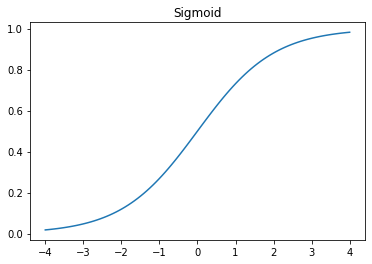

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

Let's update our definition of the `mnist_loss` function to take predictions and spread them between 0 and 1:

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Before moving forwards, a note on optimisation. If we were to calculate the loss of our model on the entire data set, it would be too slow. If we were to do it on a single item, we would only be gauging the models loss on that item. 

The best route is a compromise between the two: calculating the loss for a few titems at a time; known as a *mini-batch*. The number of items in a mini-batch is known as the batch size. A larger batch size results in a more stable estimate, but more time per epoch.

Batches can also be paralellised which is optimal for GPU processing.

We will also be shuffling our mini-batches each epoch to vary our data for better generalisation during training (avoiding over-fitting).

`DataLoader` can do this shuffling and batching for us:

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

When training a model, we not only have inputs but we have their intended targets (X and Y). 

A collection that contains tuples of independent and dependent variables is known as a `Dataset`.

Here is a simple `Dataset`:

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[9000]
x.shape,y

(torch.Size([784]), tensor([0]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

To start with, let's make our own mini-batch from the training data of size 4:

In [ ]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

Let's run our linear model against it and get the prediction tensor:

In [ ]:
preds = linear1(batch)
preds

tensor([[14.5414],
        [13.6568],
        [ 1.7618],
        [ 7.1211]], grad_fn=<AddBackward0>)

Input those predictions into our `mnist_loss` (which utlises a sigmoid function) and compare them the the dependant data (targets) `train_y` to calculate the loss: 

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0368, grad_fn=<MeanBackward0>)

Calculate the gradients:

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0046), tensor([-0.0315]))

We can combine each of the steps into a single function:
- Calculate the predictions based off a passed in model (we have been using linear1)
- Calculate the loss from those predictions
- Call `loss.backward()` to get the gradients of the weights and bias with respect to loss

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0137), tensor([-0.0944]))

**Important:** `loss.backward()` adds the gradients of loss to any gradients that are currently stored; for this reason we have to set the current gradients to zero first. This behaviour has a purose that is not yet covered.

To zero the gradients, do the following:

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

The next function updates the weights and the bias via the gradient and learning rate. 

We need to specify to Pytorch that we don't want the gradient of this step too; so we assign the data with `p.data`. We then zero out the gradients for the next step (or epoch) of loss calculation.

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

Recall that that the sigmoid function will spread the predictions across a 0->1 for us, which means now the threshold for a prediction is 0.5.

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

0.5485

Let's train one epoch to see how the accuracy compares:

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6303

Then do 20 more:

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8187 0.915 0.9443 0.956 0.9638 0.9672 0.9692 0.9702 0.9716 0.9736 0.9741 0.975 0.975 0.976 0.9765 0.9765 0.9765 0.9765 0.9765 0.9765 

A lot of what we have built manually is available in PyTorch.

Instead of creating the linear model (`linear1 = xb@weights + bias`) and initialising those weights and bias; we can make use of `nn.Linear(weightLength, biasLength) like so: 

In [ ]:
linear_model = nn.Linear(28*28, 1)  

Of which we can find the weights and biases by destructuring the returned tuple from `.paramters()`:

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimiser:

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

Making use of this class, we can recreate the same optimiser as before using the models parameters:

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

Which means we can simplify our training loop to:

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Let's put our little training loop in a function, to make things simpler:

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

0.4932 0.6724 0.8501 0.9102 0.9341 0.9516 0.9609 0.9663 0.9663 0.9692 0.9697 0.9726 0.9736 0.9746 0.9751 0.9756 0.9775 0.9785 0.9795 0.9795 

The **fastai** library provides an SGD class that covers the same functionality as our `BasicOptim` class:


In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.6943 0.8501 0.9146 0.9365 0.9512 0.9609 0.9663 0.9668 0.9692 0.9697 0.9731 0.9746 0.9751 0.9771 0.9771 0.979 0.979 0.9795 0.98 